In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        pass
        # print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [74]:
import torch
import random
import math
import importlib
import helpers
importlib.reload(helpers)
from helpers import train, score, predict, plot_random_images, unnormalize_image, run_prediction, plot_dir_contents

import torch.nn as nn
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly.express as px

from torchvision import models
from pathlib import Path
import torchvision.transforms as T
from torch.utils.data import DataLoader, Subset, random_split
from torchvision.datasets import ImageFolder
from tqdm import tqdm

device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [72]:
data_dir = Path('Face Mask Dataset')
train_dir = data_dir/'Train'
validation_dir = data_dir/'Validation'
test_dir = data_dir/'Test'

plot_dir_contents(validation_dir)

In [6]:
IMAGE_SIZE = 224

train_transforms = T.Compose([
    T.RandomResizedCrop(IMAGE_SIZE, scale=(0.7, 1.0), ratio=(0.9, 1.1)),  
    T.RandomHorizontalFlip(p=0.5),
    # T.RandomApply([T.ColorJitter(brightness=0.25, contrast=0.25, saturation=0.15, hue=0.02)], p=0.6),
    # T.RandomRotation(degrees=10), 
    T.RandomApply([T.GaussianBlur(kernel_size=3, sigma=(0.1, 1.0))], p=0.25),
    T.ToTensor(),
    T.Normalize(mean=[0.485,0.456,0.406], std=[0.229,0.224,0.225]),
    # T.RandomErasing(p=0.3, scale=(0.02, 0.15), ratio=(0.3, 3.3), value='random'),
])

val_transforms = T.Compose([
    T.Resize(int(IMAGE_SIZE*1.1)),
    T.CenterCrop(IMAGE_SIZE),
    T.ToTensor(),
    T.Normalize(mean=[0.485,0.456,0.406], std=[0.229,0.224,0.225]),
])

test_transforms = val_transforms

train_dataset = ImageFolder(train_dir, transform=train_transforms)
validation_dataset = ImageFolder(validation_dir, transform= val_transforms)
test_dataset = ImageFolder(test_dir, transform=test_transforms)

train_dataloader =DataLoader(train_dataset, batch_size=16, shuffle=True)
validation_dataloader= DataLoader(validation_dataset, batch_size=16, shuffle=False)
test_dataloader = DataLoader(test_dataset, batch_size=16, shuffle=False)
data_classes = train_dataset.classes
num_classes = len(data_classes)
data_classes_dict = train_dataset.class_to_idx
data_classes_dict

{'WithMask': 0, 'WithoutMask': 1}

In [12]:
model = models.efficientnet_b3(weights='IMAGENET1K_V1')
model = model.to(device)
final_layer = nn.Sequential(
    nn.Linear(model.classifier[1].in_features, 32),
    nn.Dropout(),
    nn.ReLU(),
    nn.Linear(32, num_classes)
)
model.classifier = final_layer
for param in model.classifier.parameters():
    param.requires_grad = False
optimizer = torch.optim.AdamW(model.parameters(), lr=.0001)
loss_fn = nn.CrossEntropyLoss()

In [7]:
# model_training_results = train(model, optimizer, loss_fn, train_dataloader, test_dataloader, epochs=25, device=device)
model = torch.load('binary_facemask_model.pth', map_location=device, weights_only=False)
model_training_results = torch.load('Model_Results_Dataframe.pth', map_location=device, weights_only=False)

In [9]:
# torch.save(model, 'binary_facemask_model.pth')
# train_losses, val_losses, train_accuracies, val_accuracies = model_training_results
# model_results_df = pd.DataFrame({'Train Accuracy': train_accuracies, 'Val Accuracy': val_accuracies, 
#              'Train Loss': train_losses, 'Val Loss': val_losses})
# torch.save(model_results_df, 'Model_Results_Dataframe.pth')
# torch.save(model, 'bunary_facemask_model.pth')

In [ ]:
train_losses = []
for img, label in tqdm(train_dataloader):
    optimizer.zero_grad()
    img, label = img.to(device), label.to(device)
    output = model(img)
    loss = loss_fn(output, label)
    loss.backward()
    optimizer.step()
    train_loss = loss.data.item() * img.size(0)
    train_losses.append(train_loss)

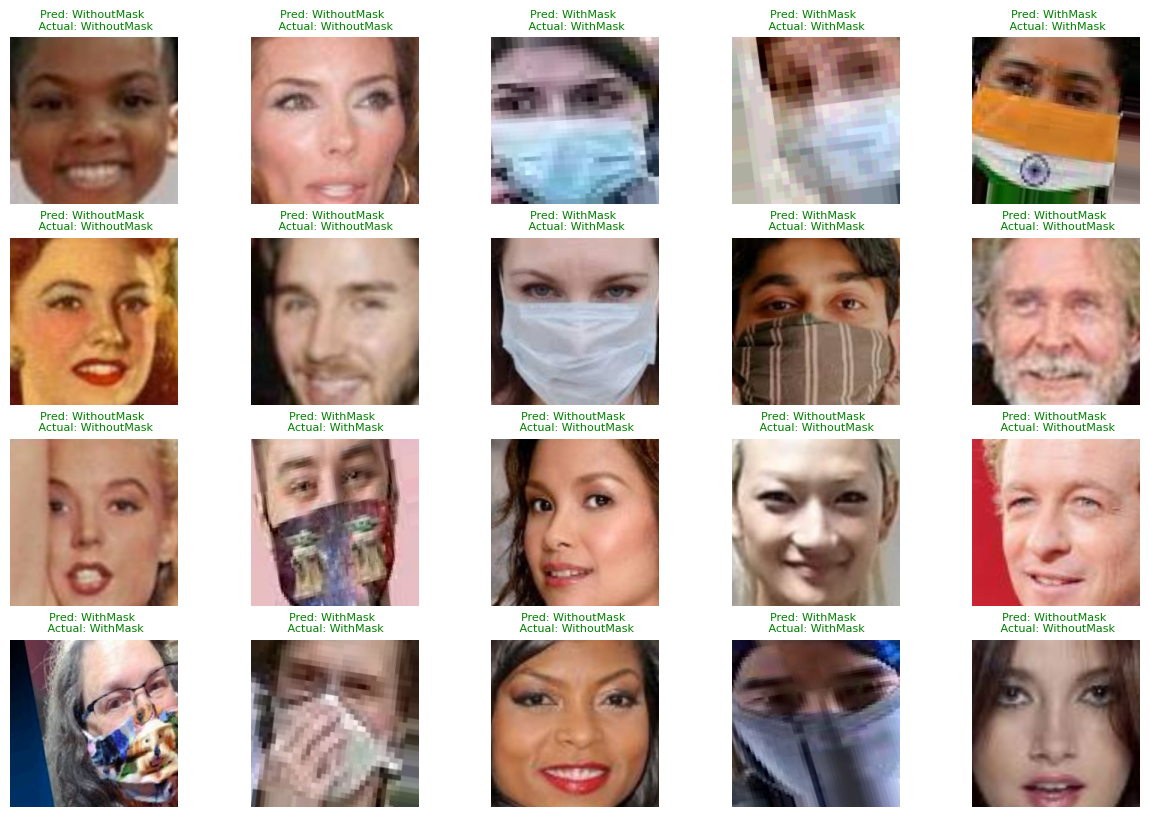

In [14]:
num_images = 20
all_preds, all_actual_labels,  all_imgs, correct, = [], [],[], 0
for _ in range(num_images):
    with torch.no_grad():
        model.eval()
        random_idx = random.choice(range(len(test_dataset)))
        img, label = test_dataset[random_idx]
        all_imgs.append(img)
        output = (model(img.unsqueeze(0)))
        pred_prob = torch.softmax(output, 1)
        pred = torch.argmax(pred_prob).item()
        if pred == label:
            correct+=1
        all_preds.append(data_classes[pred])
        all_actual_labels.append(data_classes[label])
        # model.eval()
        # output = model(img)
fig, ax = plt.subplots(figsize=(15, 10), nrows=math.ceil(num_images/5), ncols=5)
ax =ax.flatten()

for idx, axis in enumerate(ax):
    pred = all_preds[idx]
    label = all_actual_labels[idx]
    color = 'green' if pred == label else 'red'
    axis.imshow(unnormalize_image(all_imgs[idx]))
    axis.set_title(f'Pred: {all_preds[idx]} \n Actual: {all_actual_labels[idx]}', color=color, fontsize=8)
    axis.axis('off')


In [12]:
score(model, test_dataloader, loss_fn)

Scoring:   0%|          | 0/62 [00:00<?, ?it/s]

(0.012166930234900886, 0.9979838709677419)

In [28]:
model_results_df = torch.load('/kaggle/input/binary-facemask-model-and-result/pytorch/default/1/Model_Results_Dataframe.pth', weights_only=False, map_location=device)
model_results_df

,Train Accuracy,Val Accuracy,Train Loss,Val Loss
0,0.9966,0.993952,0.706319,0.361807
1,0.9956,0.994960,0.436118,1.132008
2,0.9960,0.993952,0.170083,0.403892
3,0.9955,0.986895,0.463517,3.950636
4,0.9966,0.994960,0.257900,1.067635
5,0.9968,0.993952,0.083261,0.075608
6,0.9991,1.000000,0.019410,0.006894
7,0.9950,0.986895,0.084855,0.483899
8,0.9978,0.994960,0.064498,0.144292
9,0.9974,0.994960,0.105768,0.218067


In [35]:
fig = px.line(model_results_df[['Train Accuracy', 'Val Accuracy']])
fig.update_layout(title='Training and Validation Accuracy for epochs', xaxis_title='Epochs', yaxis_title='Accuracy')
# fig.write_image('Training and Validation Accuracy for epochs.png')
fig.show()

In [36]:
fig = px.line(model_results_df[['Train Loss', 'Val Loss']])
fig.update_layout(title='Training and Validation Loss for epochs', xaxis_title='Epochs', yaxis_title='Loss')
# fig.write_image('Training and Validation Accuracy for epochs.png')
fig.show()

c:\Users\HomePC\Desktop\Python\my_project\kaggle\facemask_detection\helpers.py:211: UserWarning:

FigureCanvasAgg is non-interactive, and thus cannot be shown



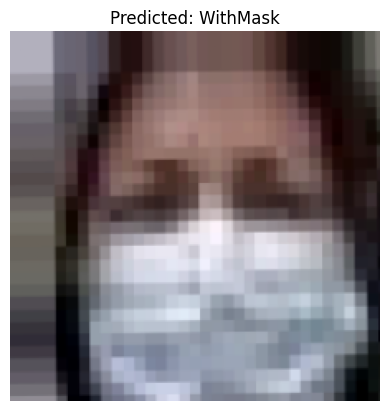

In [76]:
a = run_prediction(img_path=random_img_path, model=model);

In [77]:
a

('WithMask', 0)